# Clean RBR and inclino data

In [1]:
import os, sys, pickle, glob
import numpy as np
import matplotlib.pyplot as plt

import datetime

import pandas as pd

# cognac data and tools
import cognac.insitu as insi

---

# enregistreur: inclino

In [2]:
# data directory and filename
#
cp = insi.utils.campaign('microco_leg2.yaml')
unit = 'enregistreur'
data_dir = cp[unit]['path']+'inclino/'

dst = ['H0775','H0776']
dep = [18, 8] # found in INI files

files = [data_dir+str(ldep)+ldst+'.DAT' for ldst, ldep in zip(dst, dep)]
_ = [print(f) for f in files]

/Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/enregistreur/inclino/18H0775.DAT
/Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/enregistreur/inclino/8H0776.DAT


In [3]:
d = insi.inclino.inclino(files[0], dst[0], dayfirst=True)
print('Start time: ', d['time'][0])
print('End time: ', d['time'][-1])
print('Deployment length: ', d['time'][-1]-d['time'][0])

Start time:  2018-09-09 15:26:00
End time:  2018-09-10 03:32:34
Deployment length:  0 days 12:06:34


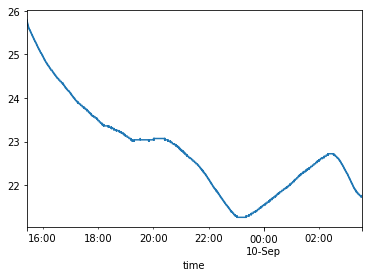

In [4]:
d['temperature'].plot()
# date format is different than for leg1

In [5]:
# Deployments from logs
print(cp[unit]['d1'])

--
Deployment label: d1
Start:
-
Event label: start
Time: 
2018-09-11 06:13:00
Lon:6.198671666666667 = 6.0deg 11.920300000000008
Lat:42.87725833333333 = 42.0deg 52.63549999999981

End:
-
Event label: end
Time: 
2018-09-11 07:31:00
Lon:6.172086666666667 = 6.0deg 10.325200000000017
Lat:42.876378333333335 = 42.0deg 52.5827000000001




The code below is useless: we set a sampling rate of 1Hz which allows deployments of 12h.

We should have used a sampling rate of 0.1Hz

In [6]:
inc={}
for r in cp[unit]:
    print(r.label)
    inc[r.label] = [insi.inclino.inclino(f,d).trim(d=r) for f,d in zip(files,dst)]
    for i in inc[r.label]:
        i.to_pickle(cp.pathp+unit+'_inclino_'+r.label+'_'+i.id+'.p')

[<cognac.insitu.inclino.inclino object at 0x1169ecf28>, <cognac.insitu.inclino.inclino object at 0x11f826fd0>]
Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/enregistreur_inclino_d1_H0775.p
Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/enregistreur_inclino_d1_H0776.p
d1
[<cognac.insitu.inclino.inclino object at 0x123d98fd0>, <cognac.insitu.inclino.inclino object at 0x11fb81fd0>]
Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/enregistreur_inclino_d2_H0775.p
Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/enregistreur_inclino_d2_H0776.p
d2


In [7]:
print(inc)

{'d1': [<cognac.insitu.inclino.inclino object at 0x1169ecf28>, <cognac.insitu.inclino.inclino object at 0x11f826fd0>], 'd2': [<cognac.insitu.inclino.inclino object at 0x123d98fd0>, <cognac.insitu.inclino.inclino object at 0x11fb81fd0>]}


---

# enregistreur RBR 

In [3]:
data_dir = cp[unit]['path']+'rbr/'

rbr = '082905'
suff = '_20180915_1238'
file = data_dir+rbr+suff+'/'+rbr+suff+'\\'+rbr+suff+'_data.txt'
print(file)

/Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/enregistreur/rbr/082905_20180915_1238/082905_20180915_1238\082905_20180915_1238_data.txt


In [4]:
# load data
R={}
for d in cp[unit]:
    R[d.label] = insi.rbr.rbr(file,rbr).trim(d=d)

In [5]:
R['d1'].d.head()

,temperature,pressure,sea_pressure,depth
time,,,,
2018-09-11 06:13:00,14.577524,61.560315,51.427814,51.111816
2018-09-11 06:13:01,14.576781,61.613836,51.481335,51.165008
2018-09-11 06:13:02,14.577385,61.241708,51.109207,50.795166
2018-09-11 06:13:03,14.580068,61.417593,51.285092,50.969971
2018-09-11 06:13:04,14.578567,61.449385,51.316884,51.001568


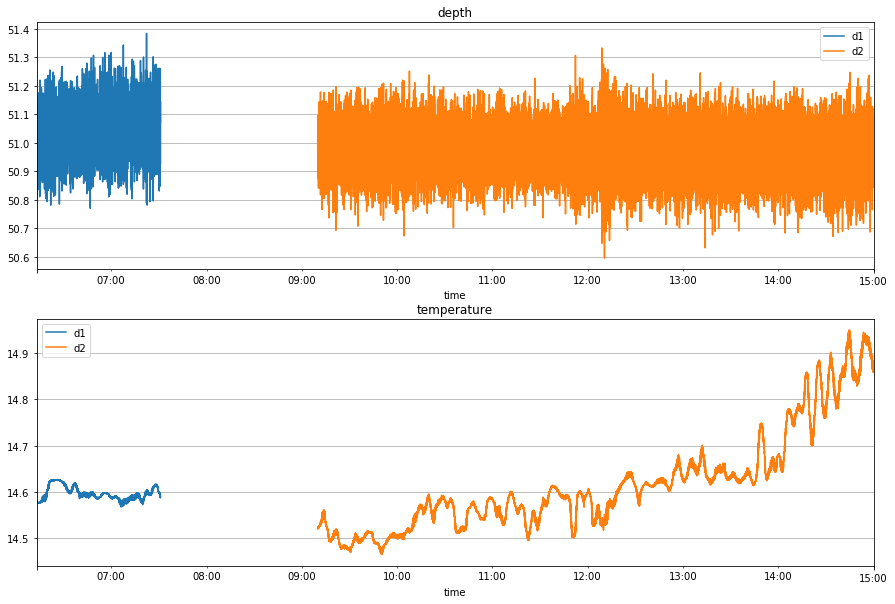

In [6]:
fig = plt.figure(figsize=(15,10))

# depth
ax = plt.subplot(211)
for i, r in R.items():
    r['depth'].plot(ax=ax, label=i)
    ax.set_title(r['depth'].name)    
    ax.grid()
    ax.legend()
        
# temperature
ax = plt.subplot(212)
for i, r in R.items():
    r['temperature'].plot(ax=ax, label=i)
    ax.set_title(r['temperature'].name)    
    ax.grid()  
    ax.legend()

In [7]:
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure

output_notebook()

TOOLS = 'pan,wheel_zoom,box_zoom,reset,help'

# subsample and compute speed
dep = 'd1'
d = R[dep].d.resample('1T').mean()
# 1T = 1 minute, 30S = 30 seconds
#print(d)
r = cp['enregistreur'][dep]

# create a new plot and add a renderer
s1 = figure(tools=TOOLS, plot_width=300, plot_height=300, title=None, 
              x_axis_type='datetime')
s1.line('time', 'temperature', source=d)
s1.add_tools(HoverTool(
    tooltips=[('time','@time{%T}'),('temperature','@{temperature}{%0.4f}'),],
    formatters={'time': 'datetime','temperature' : 'printf',},
    mode='vline'
    ))
    
s2 = figure(tools=TOOLS, plot_width=300, plot_height=300, title=None, 
               x_axis_type='datetime', x_range=s1.x_range)
s2.line('time', 'depth', source=d)
s2.add_tools(HoverTool(
    tooltips=[('time','@time{%T}'),('depth','@{depth}{%0.4f}'),],
    formatters={'time': 'datetime','depth' : 'printf',},
    mode='vline'
    ))

p = gridplot([[s1, s2]])

show(p)

Loading BokehJS ...

---

# enregistreur: store data

In [13]:
for r, i in R.items():
    #i.to_pickle(cp.pathp+unit+'_rbr_'+r+'_'+i.id+'.p')
    i.to_pickle(cp.pathp+unit+'_rbr_'+r+'.p')

Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/enregistreur_rbr_d1.p
Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/enregistreur_rbr_d2.p


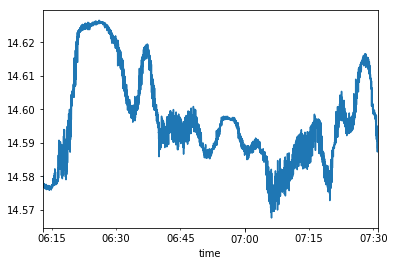

In [15]:
R['d1']['temperature'].plot()

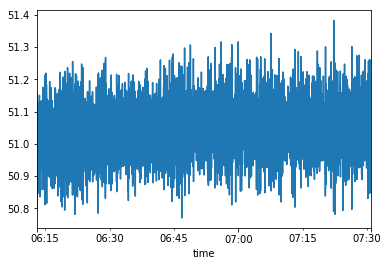

In [16]:
R['d1']['depth'].plot()

---

In [6]:
%load_ext autoreload

In [7]:
# Reload all modules (except those excluded by %aimport) automatically now.
%autoreload
#from data import *